In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

import json
import os
from PIL import Image
from pathlib import Path
from tqdm import tqdm

In [90]:
INPUT = '/kaggle/input/fashion-product-images-dataset/fashion-dataset'
BATCH_SIZE = 1
NUM_WORKERS = 1

In [91]:
base_model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
model = nn.Sequential(base_model.features,
                       base_model.avgpool)
model = model.eval()

In [92]:
class ImageFolderWithoutClasses(Dataset):
    def __init__(self, folder_path: str, transform=None):
        self.src = folder_path
        
        self.image_paths = os.listdir(folder_path)
        self.image_paths = [f'{self.src}/{path}' for path in self.image_paths
                            if path.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        x = Image.open(image_path)
        y = torch.Tensor([int(Path(image_path).stem)])
        if self.transform is not None:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.image_paths)

In [93]:
@torch.no_grad()
def get_embeddings(model,
                   dataloader,
                   device) -> np.ndarray:
    
    model.eval()
    model.to(device)
    embeddings = {}

    for x, idx in tqdm(dataloader, total=len(dataloader), miniters=1):

        x = x.to(device)
        emb = model(x)
        
        emb = emb.detach().cpu().numpy()
        emb = emb.reshape(BATCH_SIZE, -1)
        
        idx = idx.detach().cpu().numpy()
        idx = int(idx.reshape(1, -1)[0])
    
        embeddings[idx] = emb
        
    return embeddings

In [94]:
EfficientNet_V2_S_Weights.IMAGENET1K_V1.transforms

functools.partial(<class 'torchvision.transforms._presets.ImageClassification'>, crop_size=384, resize_size=384, interpolation=<InterpolationMode.BILINEAR: 'bilinear'>)

In [95]:
transformation_chain = T.Compose([
    T.Resize(384),
    T.CenterCrop(384),
    T.ToTensor()
])

In [96]:
im_fold = ImageFolderWithoutClasses(f'{INPUT}/images',
                                    transform=transformation_chain)

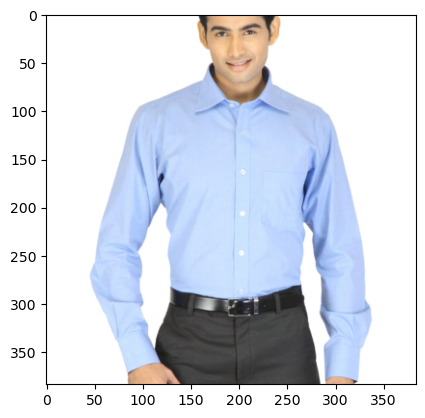

In [97]:
plt.imshow(np.transpose(im_fold.__getitem__(432)[0].cpu().detach().numpy(), (1, 2, 0)))
plt.show()

In [98]:
dataloader = DataLoader(im_fold,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS)

In [99]:
model(im_fold.__getitem__(882)[0].reshape(1, 3, 384, 384)).shape

torch.Size([1, 1280, 1, 1])

In [100]:
device = torch.device("cuda:0" if torch.cuda.is_available else 'cpu')
# device = 'cpu'
device

device(type='cuda', index=0)

In [101]:
embs = get_embeddings(model, dataloader, device)

 33%|███▎      | 14530/44441 [12:49<27:50, 17.91it/s]  Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b7cd8aca950>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
100%|██████████| 44441/44441 [39:24<00:00, 18.79it/s]  


In [102]:
all(emb.shape == (1, 1280) for emb in embs.values())

True

In [117]:
emb_1 = {key: arr.reshape(1280) for key, arr in embs.items()}

In [118]:
emb_1[31973].shape

(1280,)

In [119]:
emb_df = pd.DataFrame.from_dict(emb_1, orient='index')

NameError: name 'emd_df' is not defined

In [120]:
emb_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
31973,-0.170323,-0.127229,-0.060187,-0.097278,-0.170910,-0.096029,-0.105873,-0.102704,-0.136221,-0.137162,...,-0.055823,-0.072700,-0.127877,-0.115835,-0.174876,0.405276,-0.124576,-0.117411,-0.020822,0.239472
30778,0.391697,-0.061194,0.126656,0.013058,0.429893,0.041080,-0.004667,-0.038035,0.579874,-0.173387,...,-0.138799,0.159333,-0.106656,-0.162469,-0.223695,0.599452,0.049340,0.022449,0.068471,-0.008659
19812,0.119892,0.014674,-0.119768,0.040876,-0.173854,-0.002465,-0.073200,-0.041330,-0.103883,-0.131476,...,-0.181653,-0.014759,-0.057383,-0.109158,-0.046076,-0.208708,-0.144605,0.014420,-0.103234,-0.184659
22735,-0.226888,-0.116502,-0.124431,-0.158397,-0.199522,-0.044562,-0.104936,-0.134182,-0.118647,-0.137536,...,0.043138,-0.036557,-0.156189,-0.127886,-0.160808,0.179716,-0.157625,-0.078803,-0.112701,0.195749
38246,-0.214058,-0.047403,-0.125558,0.003935,-0.208914,-0.033213,-0.090089,-0.104340,-0.107810,-0.142475,...,-0.215830,-0.042770,-0.118221,-0.124564,-0.123393,0.648312,-0.182837,0.071630,-0.130017,-0.188203


In [121]:
emb_df = emb_df.reset_index()

In [123]:
emb_df.head()

,index,0,1,2,3,4,5,6,7,8,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,31973,-0.170323,-0.127229,-0.060187,-0.097278,-0.170910,-0.096029,-0.105873,-0.102704,-0.136221,...,-0.055823,-0.072700,-0.127877,-0.115835,-0.174876,0.405276,-0.124576,-0.117411,-0.020822,0.239472
1,30778,0.391697,-0.061194,0.126656,0.013058,0.429893,0.041080,-0.004667,-0.038035,0.579874,...,-0.138799,0.159333,-0.106656,-0.162469,-0.223695,0.599452,0.049340,0.022449,0.068471,-0.008659
2,19812,0.119892,0.014674,-0.119768,0.040876,-0.173854,-0.002465,-0.073200,-0.041330,-0.103883,...,-0.181653,-0.014759,-0.057383,-0.109158,-0.046076,-0.208708,-0.144605,0.014420,-0.103234,-0.184659
3,22735,-0.226888,-0.116502,-0.124431,-0.158397,-0.199522,-0.044562,-0.104936,-0.134182,-0.118647,...,0.043138,-0.036557,-0.156189,-0.127886,-0.160808,0.179716,-0.157625,-0.078803,-0.112701,0.195749
4,38246,-0.214058,-0.047403,-0.125558,0.003935,-0.208914,-0.033213,-0.090089,-0.104340,-0.107810,...,-0.215830,-0.042770,-0.118221,-0.124564,-0.123393,0.648312,-0.182837,0.071630,-0.130017,-0.188203


In [124]:
emb_df = emb_df.rename({'index': 'image'}, axis=1)
emb_df.head()

,image,0,1,2,3,4,5,6,7,8,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,31973,-0.170323,-0.127229,-0.060187,-0.097278,-0.170910,-0.096029,-0.105873,-0.102704,-0.136221,...,-0.055823,-0.072700,-0.127877,-0.115835,-0.174876,0.405276,-0.124576,-0.117411,-0.020822,0.239472
1,30778,0.391697,-0.061194,0.126656,0.013058,0.429893,0.041080,-0.004667,-0.038035,0.579874,...,-0.138799,0.159333,-0.106656,-0.162469,-0.223695,0.599452,0.049340,0.022449,0.068471,-0.008659
2,19812,0.119892,0.014674,-0.119768,0.040876,-0.173854,-0.002465,-0.073200,-0.041330,-0.103883,...,-0.181653,-0.014759,-0.057383,-0.109158,-0.046076,-0.208708,-0.144605,0.014420,-0.103234,-0.184659
3,22735,-0.226888,-0.116502,-0.124431,-0.158397,-0.199522,-0.044562,-0.104936,-0.134182,-0.118647,...,0.043138,-0.036557,-0.156189,-0.127886,-0.160808,0.179716,-0.157625,-0.078803,-0.112701,0.195749
4,38246,-0.214058,-0.047403,-0.125558,0.003935,-0.208914,-0.033213,-0.090089,-0.104340,-0.107810,...,-0.215830,-0.042770,-0.118221,-0.124564,-0.123393,0.648312,-0.182837,0.071630,-0.130017,-0.188203


In [125]:
emb_df.sort_values('image')

,image,0,1,2,3,4,5,6,7,8,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
32510,1163,-0.145336,-0.041878,-0.176046,-0.028096,-0.218361,-0.015948,-0.065093,-0.064611,-0.127652,...,-0.205850,-0.014110,-0.102858,-0.113289,-0.110967,1.025994,-0.143985,0.071395,-0.111719,-0.199854
12793,1164,-0.193323,-0.011561,-0.165914,0.003924,-0.220213,-0.013578,-0.046404,-0.035943,-0.085313,...,-0.207788,-0.022865,-0.109086,-0.092737,-0.116906,0.946287,-0.162938,0.066683,-0.096444,-0.197593
43186,1165,-0.015559,-0.065967,-0.105788,-0.015738,0.033136,-0.036855,-0.213496,-0.079893,0.001591,...,-0.070060,-0.058258,-0.006214,-0.149899,-0.195835,-0.029876,-0.026029,0.073804,-0.110031,-0.198158
40232,1525,0.340348,-0.022651,-0.245334,-0.120576,-0.206624,-0.000878,-0.050166,-0.052239,-0.177515,...,-0.172166,-0.024700,-0.199672,-0.113981,-0.169879,0.095903,0.091837,-0.063794,0.220904,-0.229623
34527,1526,0.213271,-0.015207,-0.205110,-0.109924,-0.203225,-0.030826,-0.052125,-0.103756,-0.115847,...,-0.195238,-0.101404,-0.183580,-0.083757,-0.149440,0.143716,0.294647,-0.060013,-0.164841,-0.228436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41810,59995,-0.197817,-0.023248,-0.164257,-0.002434,0.260946,0.002839,-0.192572,-0.055378,-0.126337,...,-0.217583,-0.117711,-0.042758,-0.186946,-0.187007,0.149759,0.020053,0.087917,-0.091127,-0.184323
36377,59996,0.026127,-0.015409,-0.103468,0.025150,0.219935,-0.028408,-0.144413,-0.084677,-0.067995,...,-0.072903,-0.113988,-0.065403,-0.077956,-0.215988,0.563559,0.068412,0.076116,-0.050842,-0.110141
41601,59998,-0.062222,-0.103354,-0.180765,-0.178663,-0.221315,0.070666,-0.098445,0.107615,-0.056593,...,-0.165731,-0.015452,-0.115589,-0.162210,-0.199950,0.364931,-0.127501,-0.063289,-0.202020,-0.209101
3875,59999,-0.108061,-0.105610,-0.195404,-0.193990,-0.224552,0.017973,-0.117498,0.300428,-0.036030,...,-0.122656,-0.042958,-0.113053,-0.212271,-0.188780,0.334588,-0.093056,-0.098756,-0.204161,-0.204428


In [130]:
st = os.listdir(f'{INPUT}/styles')
im = os.listdir(f'{INPUT}/images')
all(f'{img}.jpg' in im for img in emb_df.image), all(f'{img}.json' in st for img in emb_df.image)

(True, True)

In [131]:
hex(hash('eff net v2 s embeddings 0907'))[2:10]

'efe5f026'

In [134]:
emb_df.columns = [str(col) for col in emb_df.columns]

In [135]:
emb_df.head()

,image,0,1,2,3,4,5,6,7,8,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,31973,-0.170323,-0.127229,-0.060187,-0.097278,-0.170910,-0.096029,-0.105873,-0.102704,-0.136221,...,-0.055823,-0.072700,-0.127877,-0.115835,-0.174876,0.405276,-0.124576,-0.117411,-0.020822,0.239472
1,30778,0.391697,-0.061194,0.126656,0.013058,0.429893,0.041080,-0.004667,-0.038035,0.579874,...,-0.138799,0.159333,-0.106656,-0.162469,-0.223695,0.599452,0.049340,0.022449,0.068471,-0.008659
2,19812,0.119892,0.014674,-0.119768,0.040876,-0.173854,-0.002465,-0.073200,-0.041330,-0.103883,...,-0.181653,-0.014759,-0.057383,-0.109158,-0.046076,-0.208708,-0.144605,0.014420,-0.103234,-0.184659
3,22735,-0.226888,-0.116502,-0.124431,-0.158397,-0.199522,-0.044562,-0.104936,-0.134182,-0.118647,...,0.043138,-0.036557,-0.156189,-0.127886,-0.160808,0.179716,-0.157625,-0.078803,-0.112701,0.195749
4,38246,-0.214058,-0.047403,-0.125558,0.003935,-0.208914,-0.033213,-0.090089,-0.104340,-0.107810,...,-0.215830,-0.042770,-0.118221,-0.124564,-0.123393,0.648312,-0.182837,0.071630,-0.130017,-0.188203


In [136]:
emb_df.to_parquet('/kaggle/working/embeddings-efe5f026.parquet')